In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew, norm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

In [9]:
def split_dataset(dataset, test_ratio=0.10):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

# Define error metrics
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

## Find best model and hyperparameters

In [2]:
def load_data():
    test = pd.read_csv("./data/test.csv")
    train = pd.read_csv("./data/train.csv")

    # print("Full train dataset shape is {}".format(train.shape))
    # print("Full test dataset shape is {}".format(test.shape))

    # Store and remove Id column
    train_id = train["Id"]
    test_id = test["Id"]
    train = train.drop(labels='Id', axis=1)
    test = test.drop(labels='Id', axis=1)
    # print("Id column removed")
    # print("Full train dataset shape is {}".format(train.shape))
    # print("Full test dataset shape is {}".format(test.shape))
    return train, test 

In [20]:
def preprocess_data(train, test):
    # normalize data
    train["SalePrice"] = np.log1p(train["SalePrice"])

    train, val = split_dataset(train)

    # Split features and labels
    train_labels = train['SalePrice'].reset_index(drop=True)
    train_features = train.drop(['SalePrice'], axis=1)

    val_labels = val['SalePrice'].reset_index(drop=True)
    val_features = val.drop(['SalePrice'], axis=1)

    test_features = test
    # print("Training feature shape: {}, Validation feature shape: {}".format(
    #     train_features.shape, val_features.shape))

    TRAIN_COUNT = len(train_features)
    TEST_COUNT = len(test_features)
    VAL_COUNT = len(val_features)

    # Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
    all_features = pd.concat([train_features, test_features, val_features]).reset_index(drop=True)
    # Handle missing data
    all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
    all_features['YrSold'] = all_features['YrSold'].astype(str)
    all_features['MoSold'] = all_features['MoSold'].astype(str)

    all_features = handle_missing(all_features)

    # Transform categorial data
    all_features = pd.get_dummies(all_features).reset_index(drop=True)
    
    # Remove any duplicated column names
    all_features = all_features.loc[:,~all_features.columns.duplicated()]
    # print("All features shape", all_features.shape)

    # Recreate training and testing sets
    train_features = all_features.iloc[:TRAIN_COUNT,:]
    test_features = all_features.iloc[TRAIN_COUNT:TRAIN_COUNT+TEST_COUNT,:]
    val_features = all_features.iloc[TRAIN_COUNT+TEST_COUNT:TRAIN_COUNT+TEST_COUNT+VAL_COUNT, :]
    # print("Train features shape", train_features.shape)
    # print("Val features shape", val_features.shape)

    return train_features, train_labels, val_features, val_labels, test_features

In [13]:
train, test = load_data()
train_features, train_labels, val_features, val_labels, test_features = preprocess_data(train, test, 0.9)

In [14]:
# Random Forest
n_estimators = [100, 200, 300]
max_depth = [None, 10, 20]

for n in n_estimators:
    for md in max_depth:
        rf = RandomForestRegressor(max_depth=md, n_estimators=n)
        rf.fit(train_features, train_labels)
        val_error = rmse(rf.predict(val_features),val_labels)
        train_error = rmse(rf.predict(train_features), train_labels)
        print("n_estimators: ", n, " ", "max_depth: ",md )
        print("Validation Error", val_error, " ","Train Error", train_error)
        print("")

n_estimators:  100   max_depth:  None
Validation Error 0.13380480427603858   Train Error 0.053190708054321106

n_estimators:  100   max_depth:  10
Validation Error 0.136736969178756   Train Error 0.06247681190952879

n_estimators:  100   max_depth:  20
Validation Error 0.13278628192373154   Train Error 0.05429030585716033

n_estimators:  200   max_depth:  None
Validation Error 0.1337316376675148   Train Error 0.05305468479231673

n_estimators:  200   max_depth:  10
Validation Error 0.13461139691233512   Train Error 0.06263754331870247

n_estimators:  200   max_depth:  20
Validation Error 0.1315425902246173   Train Error 0.05312160039385449

n_estimators:  300   max_depth:  None
Validation Error 0.13396580984433945   Train Error 0.05314114348584276

n_estimators:  300   max_depth:  10
Validation Error 0.134202948374877   Train Error 0.061667366104509284

n_estimators:  300   max_depth:  20
Validation Error 0.13387299738745576   Train Error 0.05374229501439282



alpha:  0.01
Validation Error: 0.2318683499556494
Train Error: 0.0773787336571522

alpha:  0.1
Validation Error: 0.1848303679594212
Train Error: 0.07950010909016399



alpha:  1.0
Validation Error: 0.14774831415326378
Train Error: 0.08887857664529404

alpha:  10.0
Validation Error: 0.13332631936096456
Train Error: 0.10701736242128228



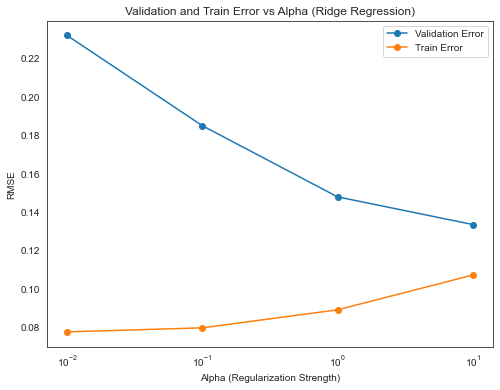

In [259]:
# Ridge
alpha = [0.01, 0.1, 1.0, 10.0]  # Example values for regularization strength

val_errors = []
train_errors = []

for a in alpha:
    ridge = Ridge(alpha=a)
    ridge.fit(train_features, train_labels)
    val_error = rmse(ridge.predict(val_features), val_labels)
    train_error = rmse(ridge.predict(train_features), train_labels)
    val_errors.append(val_error)
    train_errors.append(train_error)
    print("alpha: ", a)
    print("Validation Error:", val_error)
    print("Train Error:", train_error)
    print("")

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(alpha, val_errors, label='Validation Error', marker='o')
plt.plot(alpha, train_errors, label='Train Error', marker='o')
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('RMSE')
plt.title('Validation and Train Error vs Alpha (Ridge Regression)')
plt.legend()
plt.show()

In [15]:
# Gradient Boosting Regressor
n_estimators = [100, 200, 300]
learning_rate = [0.01, 0.1, 0.5]


for n in n_estimators:
    for lr in learning_rate:
        gbr = GradientBoostingRegressor(n_estimators=n, learning_rate=lr)
        gbr.fit(train_features, train_labels)
        val_error = rmse(gbr.predict(val_features),val_labels)
        train_error = rmse(gbr.predict(train_features), train_labels)
        print("n_estimators: ", n, " ", "learning rate: ",lr )
        print("Validation Error", val_error, " ","Train Error", train_error)
        print("")

n_estimators:  100   learning rate:  0.01
Validation Error 0.2015965074721442   Train Error 0.22589547359397996

n_estimators:  100   learning rate:  0.1
Validation Error 0.11721382480167818   Train Error 0.07927410330299234

n_estimators:  100   learning rate:  0.5
Validation Error 0.12909355054684257   Train Error 0.04249823093554201

n_estimators:  200   learning rate:  0.01
Validation Error 0.15015433336753267   Train Error 0.15555814403628376

n_estimators:  200   learning rate:  0.1
Validation Error 0.1170041317234934   Train Error 0.06161679619590923

n_estimators:  200   learning rate:  0.5
Validation Error 0.12670696901352432   Train Error 0.02014462671609269

n_estimators:  300   learning rate:  0.01
Validation Error 0.1306018078346519   Train Error 0.1253526295876217

n_estimators:  300   learning rate:  0.1
Validation Error 0.11905363073063295   Train Error 0.051049993157500716

n_estimators:  300   learning rate:  0.5
Validation Error 0.12317036556345759   Train Error 0.01

In [267]:
# Retrain best model and parameters on full data
train, test = load_data()
train_features, train_labels, val_features, val_labels, test_features = preprocess_data(train, test, 1)

full_train_features = pd.concat([train_features, val_features]) 
full_train_labels = pd.concat([train_labels, val_labels]) 
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1)

gbr.fit(full_train_features, full_train_labels)

submission = pd.read_csv("./data/sample_submission.csv")
predictions = np.floor(np.expm1(gbr.predict(test_features)))
submission.iloc[:,1] = predictions
submission.to_csv("submission.csv", index=False)

### Compare Training Size

In [5]:
def train_with_best_params(train_features, train_labels):  
    rf = RandomForestRegressor(max_depth=None, n_estimators=100)
    rf.fit(train_features, train_labels)

    ridge = Ridge(alpha=10)
    ridge.fit(train_features, train_labels)

    gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1)
    gbr.fit(train_features, train_labels)

    return rf, ridge, gbr

def predict(model, name, ratio, test_features):
    submission = pd.read_csv("./data/sample_submission.csv")
    predictions = np.floor(np.expm1(model.predict(test_features)))
    submission.iloc[:,1] = predictions
    submission.to_csv("submission_" + name + "_" + str(ratio) + ".csv", index=False)

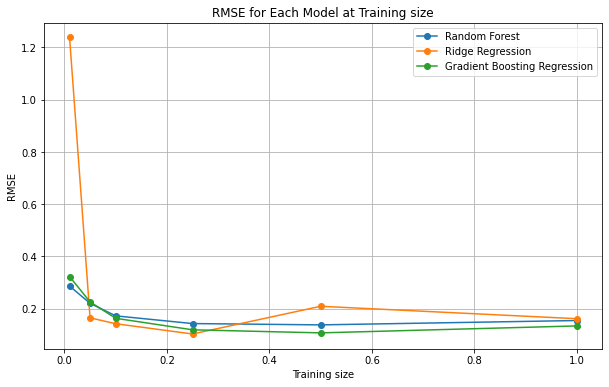

In [37]:
ratio_values = [0.01, 0.05, 0.1, 0.25, 0.5, 1]

rf_rmse_values = []
ridge_rmse_values = []
gbr_rmse_values = []
for ratio in ratio_values:
    train, test = load_data()
    train_features, train_labels, val_features, val_labels, test_features = preprocess_data(train, test)

    train_features = train_features[:int(len(train_features) * ratio)]
    train_labels = train_labels[:int(len(train_labels) * ratio)]
    
    rf, ridge, gbr = train_with_best_params(train_features, train_labels)
    rf_rmse = rmse(rf.predict(val_features),val_labels)
    ridge_rmse = rmse(ridge.predict(val_features),val_labels)
    gbr_rmse = rmse(gbr.predict(val_features),val_labels)

    rf_rmse_values.append(rf_rmse)
    ridge_rmse_values.append(ridge_rmse)
    gbr_rmse_values.append(gbr_rmse)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(ratio_values, rf_rmse_values, label='Random Forest', marker='o')
plt.plot(ratio_values, ridge_rmse_values, label='Ridge Regression', marker='o')
plt.plot(ratio_values, gbr_rmse_values, label='Gradient Boosting Regression', marker='o')

plt.xlabel('Training size')
plt.ylabel('RMSE')
plt.title('RMSE for Each Model at Training size')
plt.legend()
plt.grid(True)
plt.show()



### Stretch Goals

In [16]:
# Blend models in order to make the final predictions more robust to overfitting
def predict_blended(rf, ridge, gbr, test_features):
    return ((0.25 * rf.predict(test_features)) + \
            (0.25 * ridge.predict(test_features)) + \
            (0.5 * gbr.predict(test_features)))

In [17]:
train, test = load_data()
train_features, train_labels, val_features, val_labels, test_features = preprocess_data(train, test, 1)
rf_model, ridge_model, gbr_model = train_with_best_params(train_features, train_labels)
predictions = np.floor(np.expm1(predict_blended(rf_model, ridge_model, gbr_model, test_features)))
submission = pd.read_csv("./data/sample_submission.csv")
submission.iloc[:,1] = predictions
submission.to_csv("blended.csv", index=False)